# EDA and Visualizations for Monte Carlo simulation

In [349]:
import sys
import os
sys.path.append(os.path.abspath('../src'))

In [350]:
import matplotlib.pyplot as plt
import seaborn as sns
from risk_metrics import compute_var, compute_cvar
import pandas as pd
import numpy as np

**Loss simulation**

In [351]:
from simulate import simulate_portfolio_losses
import numpy as np

mu = np.load("../data/mu.npy")
sigma = np.load("../data/sigma.npy")
weights = np.ones_like(mu) / len(mu)
tickers = ['AMZN', 'SBUX', 'NKE', 'AAPL', 'TSLA', 'GOOGL', 'META', 'WMT', 'ADDYY']

losses = simulate_portfolio_losses(mu, sigma, weights, T=10, N=10000)
var_95 = compute_var(losses, 0.95)
cvar_95 = compute_cvar(losses, 0.95)




**Histogram of data**

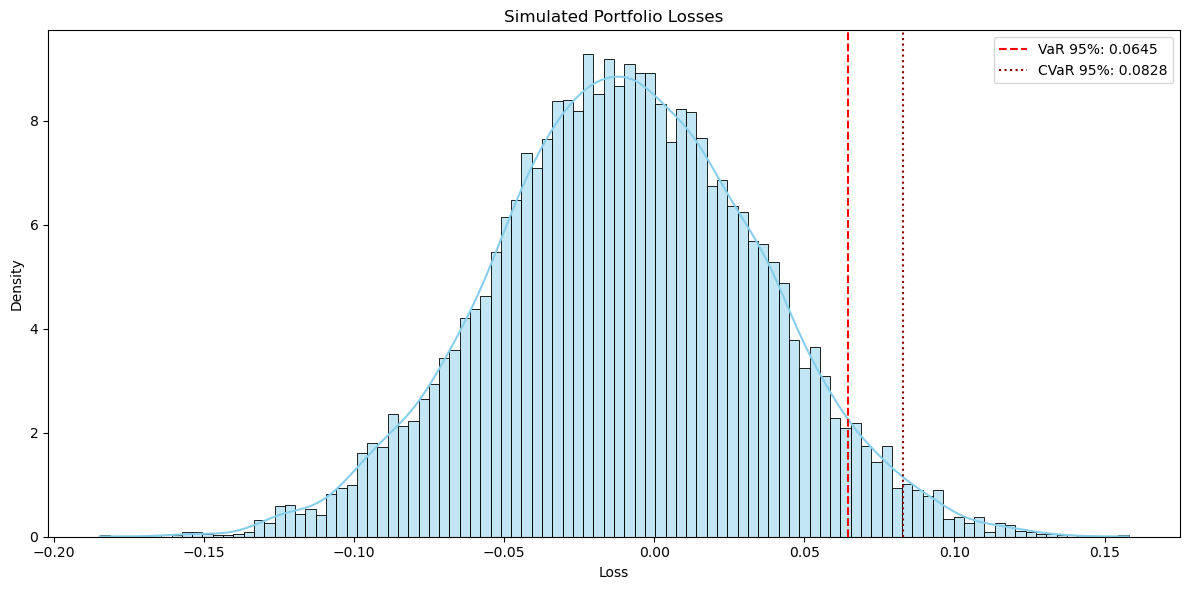

In [352]:
plt.figure(figsize=(12, 6))
sns.histplot(losses, bins=100, kde=True, color='skyblue', stat='density')
plt.axvline(var_95, color='red', linestyle='--', label=f'VaR 95%: {var_95:.4f}')
plt.axvline(cvar_95, color='darkred', linestyle=':', label=f'CVaR 95%: {cvar_95:.4f}')
plt.title('Simulated Portfolio Losses')
plt.xlabel('Loss')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()


**Correlation Heatmap**

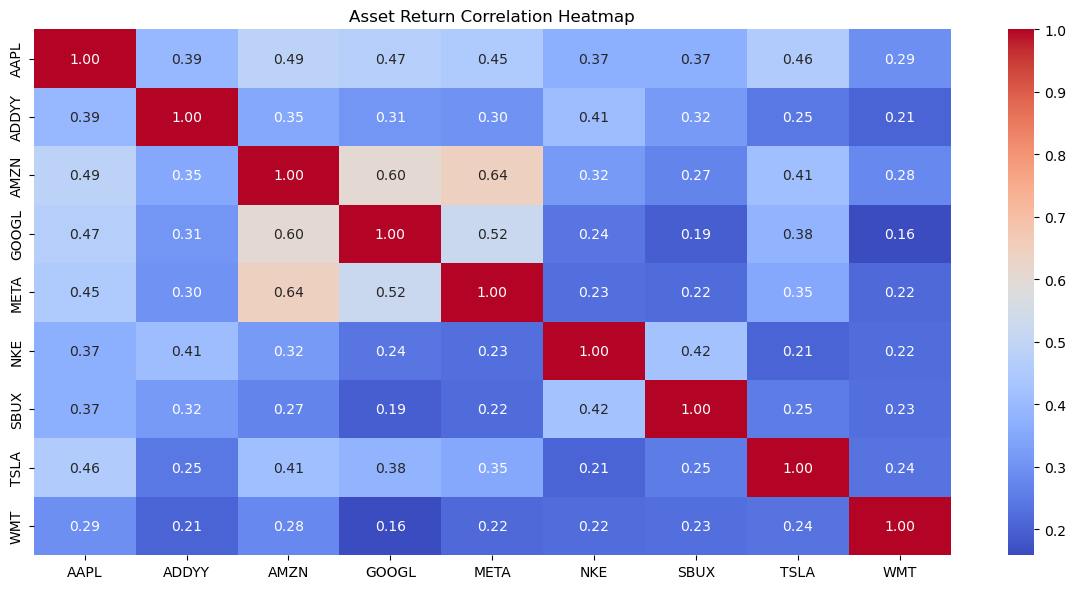

In [353]:
# Load historical log returns
returns_df = pd.read_csv("../data/historical_returns.csv", index_col=0, parse_dates=True)
corr_matrix = returns_df.corr()

plt.figure(figsize=(12,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Asset Return Correlation Heatmap")
plt.tight_layout()
plt.show()

**Rolling Volatility**

<Figure size 1200x600 with 0 Axes>

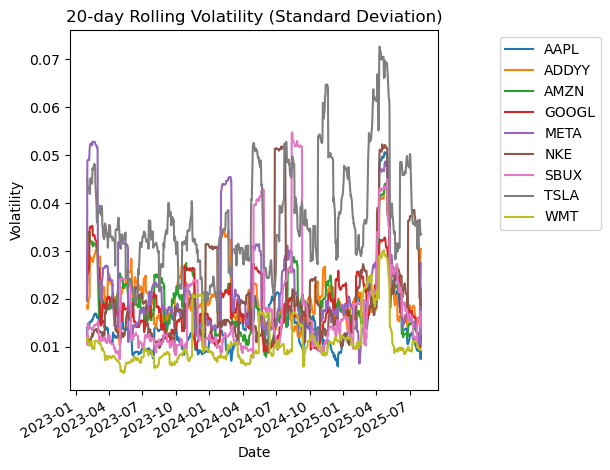

In [354]:
# Rolling 20-day standard deviation
rolling_vol = returns_df.rolling(window=20).std()

plt.figure(figsize=(12,6))
rolling_vol.plot()
plt.title('20-day Rolling Volatility (Standard Deviation)')
plt.ylabel('Volatility')
plt.xlabel('Date')
plt.legend(loc='upper left', bbox_to_anchor=(1.15, 1))
plt.tight_layout()
plt.show()


**Potential Worst Losses**

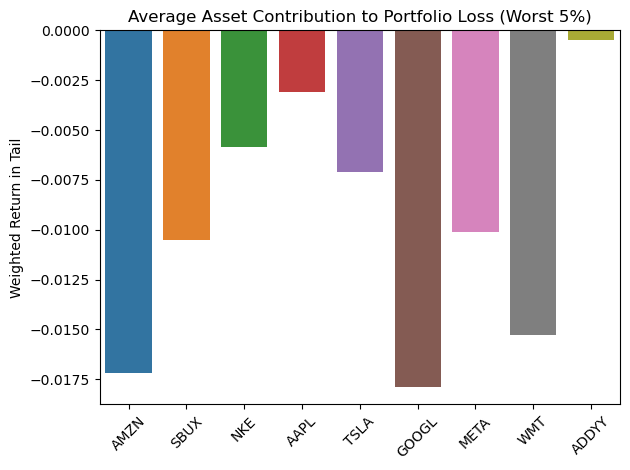

In [356]:

# Simulate all asset-level returns
simulated_returns = np.random.multivariate_normal(mu * 10, sigma * 10, size=100000)

# Get losses for each simulation
portfolio_returns = np.dot(simulated_returns, weights)
losses = -portfolio_returns

# Mask worst 5%
worst_idx = losses >= compute_var(losses, 0.95)
worst_returns = simulated_returns[worst_idx]  # shape (N_worst, d)

# Weighted contribution per asset
avg_contributions = worst_returns.mean(axis=0) * weights

# Plot
import matplotlib.pyplot as plt
import seaborn as sns
sns.barplot(x=tickers, y=avg_contributions)
plt.title("Average Asset Contribution to Portfolio Loss (Worst 5%)")
plt.ylabel("Weighted Return in Tail")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()